# Deep Compression: Compressing deep neural network

## 0.1 Introduction

Une grande partie du succès du deep learning provient de la construction de réseaux de neurones de plus en plus grands. Ces réseaux, de part leur complexité peuvent être demandant en calcul et en mémoire, ce qui les rend difficiles à déployer sur des systèmes embarqués avec des ressources matérielles limitées. La compression de modèle vise à réduire la taille des modèles tout en minimisant la perte de précision ou de performance. Une application utile de ces techniques de compression est par exemple le fait de pouvoir implémenter ces réseaux sur de petit appareils comme nos téléphone en limitant l'espace de mémoire requis, le temps d'exécution et la puissance consommée.



Afin de réduire la taille et la complexité de ces réseau, l'article [[1]](#bib) présente une solution possible: la "compression profonde", un méthode en trois étapes: pruning, trained quantization et Huffman coding, qui ensemble permettent de réduire considérablement (de 35x à 49x) les besoins de stockage des réseaux de neurones sans en affecter leur précision. 

Ce notebook s'intéresse donc à la compression des réseaux de neurones et présente une implémentation de deux des techniques présentées dans l'article : le pruning et la quantification des poids.

In [1]:
#au cas ou il ne serait as déjà installé
!pip install torch torchvision pytorch-ignite

In [2]:
import torch
import torchvision
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In C:\Users\32474\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\32474\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\32474\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\32474\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\32474\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

# 0.2. Importation des données

Nous commencons par importer les données de MNIST. La base de données MNIST représente des chiffres manuscrits et contient un ensemble de training de 60 000 exemples et un ensemble de test de 10 000 exemples.

In [3]:
import torchvision.transforms as transforms

transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

trainset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

print(len(trainset))
print(len(testset))

#afin d'avoir un temps d'exécution pas trop important on ne prend qu'une partie des données
trainset, _ = torch.utils.data.random_split(trainset, (10000, 50000))
testset, _ = torch.utils.data.random_split(testset, (1000, 9000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

60000
10000


Regardons à quoi ressemble un élément de notre set de données

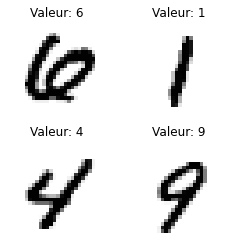

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(4,4))
for i in range(4):
    l = labels[i].numpy()
    plt.subplot(2, 2, i+1)
    plt.title('%s: %d' % ("Valeur",l ))
    plt.imshow(images[i].numpy()[0], cmap='Greys')
    plt.axis('off')

# 1. Pruning

Les réseaux de neurones sont souvent sur-paramétrés et de nombreuses connexions entre neurones ne jouent pas forcément un rôle primordiale à la bonne exécution de celui-ci. 

L'élagage du réseau de neurones est une méthode de compression qui consiste à supprimer des poids d'un modèle entraîné. Il existe différentes manières d'élaguer un réseau neuronal. 

- On peut supprimer des poids. Cela se fait en définissant les paramètres individuels à zéro. On réduit le nombre de paramètres dans le modèle tout en conservant la même architecture. 
- On peut supprimer des nœuds entiers du réseau. Cela rendrait l'architecture du réseau elle-même plus petite, tout en visant à conserver la précision du plus grand réseau initial.

<img src="img/pruning.png" width="50%"> (© [[4]](#bib))
# 


Nous allons reproduire dans ce notebook le réseau LeNet-300-100 et nous concentrer sur la première méthode, la suppression de certains poids. Ce réseau a déjà été utilisé dans plusieurs articles afin d'évaluer la puissance et la qualité des méthodes de compression [[2]](#bib), [[3]](#bib). 

Il se compose de deux couches cachées de 300 et 100 neurones. Il y a 784 entrées (représentant les pixels d'une image de 28x28) et 10 sorties pour les chiffre de 0 à 9.

<img src="img/LeNet.png" width="30%">

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.fc1 = MaskedLinear(784, 300)
        self.fc2 = MaskedLinear(300, 100)
        self.fc3 = MaskedLinear(100, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1.forward(x))
        x = F.relu(self.fc2.forward(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


Comme on peut le voir dans la cellule ci-dessus, nous allons définir pour ce modèle notre propre classe pour représenter une couche de neurones afin de pouvoir la manipuler plus facilement et lui ajouter des méthodes supplémentaires.

On aimerait en effet pouvoir supprimer par la suite certains poids (c-à-d connexion entre deux neurones) dans le but de réduire la taille de notre modèle.

Pour ce faire nous allons créer un masque (composer de 0 ou de 1) de la même taille que la matrice représentant les poids de la couche de neurones. Ce masque détermine si un poids particulier doit être utilisé ou non. Nous initialisons ce masque avec des 1 car nous commencerons par considérer tous les poids et supprimerons les poids inutiles par la suite.

In [6]:

class MaskedLinear(nn.Module):
    """Applies a masked linear transformation to the incoming data: :math:`y = (A * M)x + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample

    Attributes:
        weight: the learnable weights of the module of shape
            (out_features x in_features)
        bias:   the learnable bias of the module of shape (out_features)
        mask: the unlearnable mask for the weight.
            It has the same shape as weight (out_features x in_features)

    """
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        
        # Initialisation du masque avec des 1
        self.mask = nn.Parameter(torch.ones([out_features, in_features]), requires_grad=False)
        
        #initioalisation des poids et biais
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        # Produit element par element entre les poids et le masque pour ignorer
        # certaines connexions entre neurones
        return F.linear(input, self.weight * self.mask, self.bias)

    def __repr__(self):
        # Affichage des paramètres du réseau
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', bias=' + str(self.bias is not None) + ')'

    def prune(self, threshold):
        """
        Supprime les poids de la couche si ceux-ci sont inférieurs au treshold
        """
        # converti les tenseur vers numpy
        tensor = self.weight.data.cpu().numpy()
        mask = self.mask.data.cpu().numpy()
        
        #met un zero dans le masque (supprime la connexion) si le poids est inférieur à un treshold donné
        new_mask = np.where(abs(tensor) < threshold, 0, mask) #0 si vrai, mask sinon
        
        # applique les nouveau poids et masque
        self.weight.data = torch.from_numpy(tensor * new_mask)
        self.mask.data = torch.from_numpy(new_mask)

#### Quels neurones ou connexions peut-on supprimer ?

Un défi majeur dans la suppression des poids est de déterminer lesquelles enlever. Il existe différentes heuristiques et méthodes pour déterminer quels paramètres sont moins importants et peuvent être supprimés avec un effet minimal sur la précision. Le but est de supprimer davantage de paramètres moins importants.

L'un des moyens les plus simples de compression est basé sur l'ampleur du poids. Supprimer un poids revient essentiellement à le remettre à zéro. On peut minimiser l'effet sur le réseau en supprimant les pondérations qui sont déjà proches de zéro. Cela peut être mis en œuvre en supprimant tous les poids inférieurs (en valeur absolue) à un certain seuil. 


Alternativement, on peut également supprimer des neurones entiers comme le propose [[3]](#bib). Lors de l'exécution d'un jeu de données via un réseau, certaines statistiques des activations peuvent être observées. Certains neurones produisent toujours des valeurs proches de zéro et ces neurones peuvent probablement être supprimés avec peu d'impact sur le modèle. L’intuition est que si un neurone s’active rarement avec une valeur élevée, il est rarement utilisé dans la tâche du modèle.

De plus la redondance des paramètres entre deux neurone d'une même couche peut signifier qu'un de ces neurones peut probablement être supprimé. Si deux neurones dans une couche ont des poids ou des activations très similaires, cela peut signifier qu'ils *font la même chose*.  Par cette intuition, nous pouvons donc supprimer l'un des neurones tout en conservant une précision semblable.

Idéalement dans un réseau de neurones, tous les neurones ont des paramètres uniques et des activations de sortie qui sont d'une ampleur significative (sinon on peut supprimer des connexions) et non redondantes (sinon on peut supprimer des neurones).

Pour la suite de ce notebook nous nous concentrerons sur la suppression des connexions entre neurones en annulant les poids en question. La méthode *prune()* définie ci-dessus permettra de supprimer les poids inférieurs à une certaine valeur de "*treshold*"


Commencons par instancier notre réseau LeNet-300-100.

In [7]:
model = LeNet()

#affiche les caractéristiques de notre modèle 
print(f"{'Param name':20} {'Shape':30} {'Type':15}")
print('-'*70)
for name, param in model.named_parameters():
    print(f'{name:20} {str(param.shape):30} {str(param.dtype):15}')

Param name           Shape                          Type           
----------------------------------------------------------------------
fc1.weight           torch.Size([300, 784])         torch.float32  
fc1.bias             torch.Size([300])              torch.float32  
fc1.mask             torch.Size([300, 784])         torch.float32  
fc2.weight           torch.Size([100, 300])         torch.float32  
fc2.bias             torch.Size([100])              torch.float32  
fc2.mask             torch.Size([100, 300])         torch.float32  
fc3.weight           torch.Size([10, 100])          torch.float32  
fc3.bias             torch.Size([10])               torch.float32  
fc3.mask             torch.Size([10, 100])          torch.float32  


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
initial_optimizer_state_dict = optimizer.state_dict()

Nous allons maintenant définir les fonctions qui permettrons d'entrainer notre modèle et d'évaluer la précision de celui-ci.

In [9]:
from tqdm import tqdm
def train(epochs):
    model.train()
    for epoch in range(epochs):
        pbar = tqdm(enumerate(trainloader), total=len(trainloader)) #pour une animation lors de l'entrainement du modèle
        for batch_idx, (data, target) in pbar:
            data, target = data, target
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()

            # zero-out all the gradients corresponding to the pruned connections
            for name, p in model.named_parameters():
                if 'mask' in name:
                    continue
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                grad_tensor = np.where(tensor==0, 0, grad_tensor)
                p.grad.data = torch.from_numpy(grad_tensor)

            optimizer.step()
            if batch_idx % 10 == 0:
                done = batch_idx * len(data)
                percentage = 100. * batch_idx / len(trainloader)
                pbar.set_description(f'Train Epoch: {epoch} [{done:5}/{len(trainloader.dataset)} ({percentage:3.0f}%)]  Loss: {loss.item():.6f}')

Test de la précision du modèle avec les données de test.

In [10]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        test_loss /= len(testloader.dataset)
        accuracy = 100. * correct / len(testloader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(testloader.dataset)} ({accuracy:.2f}%)')
    return accuracy

Fonction permettant d'afficher le pourcentage de connexions supprimées.

In [11]:
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        if 'mask' in name:
            continue
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')

#### Entrainement initial du modèle

Nous commencons par entrainer notre réseau complet avec tous les poids potentiellement non nuls.

In [12]:
# Initial training
print("--- Initial training ---")
train(10) #nbr of epochs

--- Initial training ---


Train Epoch: 0 [ 9600/10000 ( 96%)]  Loss: 0.375352: 100%|██████████| 157/157 [00:01<00:00, 79.83it/s]
Train Epoch: 1 [ 9600/10000 ( 96%)]  Loss: 0.050324: 100%|██████████| 157/157 [00:02<00:00, 72.85it/s]
Train Epoch: 2 [ 9600/10000 ( 96%)]  Loss: 0.129923: 100%|██████████| 157/157 [00:02<00:00, 73.36it/s]
Train Epoch: 3 [ 9600/10000 ( 96%)]  Loss: 0.027568: 100%|██████████| 157/157 [00:02<00:00, 69.86it/s]
Train Epoch: 4 [ 9600/10000 ( 96%)]  Loss: 0.016607: 100%|██████████| 157/157 [00:02<00:00, 76.72it/s]
Train Epoch: 5 [ 9600/10000 ( 96%)]  Loss: 0.060555: 100%|██████████| 157/157 [00:02<00:00, 77.82it/s]
Train Epoch: 6 [ 9600/10000 ( 96%)]  Loss: 0.026022: 100%|██████████| 157/157 [00:01<00:00, 84.36it/s]
Train Epoch: 7 [ 9600/10000 ( 96%)]  Loss: 0.013111: 100%|██████████| 157/157 [00:01<00:00, 82.20it/s]
Train Epoch: 8 [ 9600/10000 ( 96%)]  Loss: 0.056119: 100%|██████████| 157/157 [00:01<00:00, 79.95it/s]
Train Epoch: 9 [ 9600/10000 ( 96%)]  Loss: 0.006625: 100%|██████████| 157

Nous regardons ensuite la précision de notre modèle et nous pouvons également vérifier que la majorité des poids ne sont pas nul (On a en effet supprimer encore aucune connexion)

In [13]:

print("--- Before pruning ---")
test()
print_nonzeros(model)

--- Before pruning ---
Test set: Average loss: 0.0954, Accuracy: 974/1000 (97.40%)
fc1.weight           | nonzeros =  235200 /  235200 (100.00%) | total_pruned =       0 | shape = (300, 784)
fc1.bias             | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
fc2.weight           | nonzeros =   30000 /   30000 (100.00%) | total_pruned =       0 | shape = (100, 300)
fc2.bias             | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
fc3.weight           | nonzeros =    1000 /    1000 (100.00%) | total_pruned =       0 | shape = (10, 100)
fc3.bias             | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 266610, pruned : 0, total: 266610, Compression rate :       1.00x  (  0.00% pruned)


In [14]:
#poids d'un des neurone de la dernière couche
print(model.fc3.weight[0])

tensor([-4.8707e-02,  9.9229e-03, -1.2400e-02, -5.6901e-05, -5.1290e-02,
         3.0853e-02,  7.1772e-02,  8.4386e-02, -1.0330e-02,  9.6612e-02,
         7.5593e-02,  4.8359e-02,  1.3008e-02, -1.0121e-01,  2.9765e-03,
        -1.1927e-02, -4.4987e-04, -1.5238e-01,  5.3286e-02,  8.4578e-02,
         7.7271e-02, -4.4730e-02,  1.1816e-01, -7.6085e-02,  2.7984e-02,
         1.0889e-01, -6.4700e-02,  1.1584e-01, -1.4126e-01,  1.3968e-01,
         5.6004e-03, -5.8737e-02, -9.5116e-02,  1.2062e-01, -1.2430e-01,
         2.8648e-03,  1.1506e-02,  1.2208e-01, -9.7791e-02, -7.3561e-02,
        -1.7193e-01,  3.8486e-02, -1.1485e-01,  8.2517e-02,  3.4351e-02,
        -2.1138e-01,  7.5399e-02,  8.1441e-02, -6.1288e-04, -7.7396e-02,
         8.1734e-02,  6.6188e-02,  9.2524e-02, -1.4867e-01,  1.4140e-01,
        -1.2114e-01, -1.5430e-01, -1.1504e-01, -1.5686e-01,  5.6746e-02,
        -5.1209e-02, -1.8004e-01, -1.1146e-02, -1.6594e-01,  6.8720e-02,
         4.3338e-02,  2.4284e-02, -4.5784e-02, -6.3

#### Suppression de certaine connexion

Nous pouvons maintenant supprimer des connexions entre neurones dont le rôle serait peu important

Une des méthodes possibles afin de déterminer le seuil à partir duquel une connexion peut être supprimée est présentée dans un article précédent du même auteur Song Hang: *Learning both Weights and Connections for Efficient Neural Networks*.



<a id='sParam'></a>
Dans cette article **s** est définit comme un paramètre de qualité / valeur de sensibilité.
Et le seuil de suppression est choisi comme ce paramètre de qualité multiplié par l'écart type des poids d'une couche.

In [15]:
s = 1
for name, module in model.named_modules():
            if name in ['fc1', 'fc2', 'fc3']:
                threshold = np.std(module.weight.data.cpu().numpy()) * s
                print(f'Pruning with threshold : {threshold} for layer {name}')
                module.prune(threshold)

Pruning with threshold : 0.03382377326488495 for layer fc1
Pruning with threshold : 0.05046878755092621 for layer fc2
Pruning with threshold : 0.08708547800779343 for layer fc3


In [16]:
print("--- After pruning ---")
test()
print_nonzeros(model)

--- After pruning ---
Test set: Average loss: 0.1725, Accuracy: 944/1000 (94.40%)
fc1.weight           | nonzeros =   56970 /  235200 ( 24.22%) | total_pruned =  178230 | shape = (300, 784)
fc1.bias             | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
fc2.weight           | nonzeros =    8806 /   30000 ( 29.35%) | total_pruned =   21194 | shape = (100, 300)
fc2.bias             | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
fc3.weight           | nonzeros =     361 /    1000 ( 36.10%) | total_pruned =     639 | shape = (10, 100)
fc3.bias             | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 66547, pruned : 200063, total: 266610, Compression rate :       4.01x  ( 75.04% pruned)


On note une faible baisse de la précision (de l'ordre de 3 %) pour un nombre important de parmaètre supprimés (de l'odre de 75% !).

On peut examiner à nouveau les poids d'un des neurones de la couche de sortie et constater que la majorité des poids ont bien été annulés. 

In [17]:
print(model.fc3.weight[0])

tensor([-0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
        -0.0000,  0.0966,  0.0000,  0.0000,  0.0000, -0.1012,  0.0000, -0.0000,
        -0.0000, -0.1524,  0.0000,  0.0000,  0.0000, -0.0000,  0.1182, -0.0000,
         0.0000,  0.1089, -0.0000,  0.1158, -0.1413,  0.1397,  0.0000, -0.0000,
        -0.0951,  0.1206, -0.1243,  0.0000,  0.0000,  0.1221, -0.0978, -0.0000,
        -0.1719,  0.0000, -0.1149,  0.0000,  0.0000, -0.2114,  0.0000,  0.0000,
        -0.0000, -0.0000,  0.0000,  0.0000,  0.0925, -0.1487,  0.1414, -0.1211,
        -0.1543, -0.1150, -0.1569,  0.0000, -0.0000, -0.1800, -0.0000, -0.1659,
         0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0982, -0.0000,
        -0.0949,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.1500,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
        -0.1276, -0.0000, -0.0000, -0.1609, -0.0000,  0.0000, -0.0000, -0.1414,
         0.1156,  0.0000, -0.0000, -0.14

#### Réentrainement du modèle réduit

Une fois la majorité des poids annulée on peut réentrainer notre réseau tout en maintenant les poids des connexions supprimées à 0 grâce au masque crée lors de la définition de la classe **MaskedLinear** (représentant une couche de neurones et les connexions supprimées).

<img src="img/pruning2.png" width="20%"> (© [[4]](#bib))

In [18]:
# Retrain
print("--- Retraining ---")
optimizer.load_state_dict(initial_optimizer_state_dict) # Reset the optimizer
train(10)

print("--- After Retraining ---")
test()
print_nonzeros(model)

  0%|          | 0/157 [00:00<?, ?it/s]

--- Retraining ---


Train Epoch: 0 [ 9600/10000 ( 96%)]  Loss: 0.004569: 100%|██████████| 157/157 [00:02<00:00, 64.80it/s]
Train Epoch: 1 [ 9600/10000 ( 96%)]  Loss: 0.008640: 100%|██████████| 157/157 [00:01<00:00, 81.73it/s]
Train Epoch: 2 [ 9600/10000 ( 96%)]  Loss: 0.002100: 100%|██████████| 157/157 [00:02<00:00, 73.63it/s]
Train Epoch: 3 [ 9600/10000 ( 96%)]  Loss: 0.020026: 100%|██████████| 157/157 [00:02<00:00, 72.23it/s]
Train Epoch: 4 [ 9600/10000 ( 96%)]  Loss: 0.005320: 100%|██████████| 157/157 [00:02<00:00, 73.29it/s]
Train Epoch: 5 [ 9600/10000 ( 96%)]  Loss: 0.002949: 100%|██████████| 157/157 [00:02<00:00, 53.60it/s]
Train Epoch: 6 [ 9600/10000 ( 96%)]  Loss: 0.005762: 100%|██████████| 157/157 [00:02<00:00, 74.88it/s]
Train Epoch: 7 [ 9600/10000 ( 96%)]  Loss: 0.001660: 100%|██████████| 157/157 [00:02<00:00, 66.53it/s]
Train Epoch: 8 [ 9600/10000 ( 96%)]  Loss: 0.000583: 100%|██████████| 157/157 [00:02<00:00, 73.36it/s]
Train Epoch: 9 [ 9600/10000 ( 96%)]  Loss: 0.002763: 100%|██████████| 157

--- After Retraining ---
Test set: Average loss: 0.1145, Accuracy: 971/1000 (97.10%)
fc1.weight           | nonzeros =   56970 /  235200 ( 24.22%) | total_pruned =  178230 | shape = (300, 784)
fc1.bias             | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
fc2.weight           | nonzeros =    8806 /   30000 ( 29.35%) | total_pruned =   21194 | shape = (100, 300)
fc2.bias             | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
fc3.weight           | nonzeros =     361 /    1000 ( 36.10%) | total_pruned =     639 | shape = (10, 100)
fc3.bias             | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 66547, pruned : 200063, total: 266610, Compression rate :       4.01x  ( 75.04% pruned)


On retrouve une précision acrue et qui dépasse même parfois la précision initiale alors qu'une grande partie des poids (~75%) ont été supprimés! (Ceci est dû au fait que nous n'avons pas entrainé suffisament notre modèle initial pour atteindre une précision optimale afin que le code puisse tourner relativement vite)

Vous pouvez jouer avec le paramètre **s** ([ici](#sParam)) en l'augmentant et vérifier jusqu'à quel niveau on peut supprimer des paramètres du réseau tout en conservant sa précision. (Non mais vraiment faites-le c'est impressionnant 😉 )

# <a id="sec2">2. Trained quantization and weight sharing</a>

Passons maintenant à l'étape suivante de compression. (Si vous avez abusé avec la paramètre **s**  remettez le vers *1* et relancez les cellules précédentes: *Run* => *run all above selected cell* et attendez un petit peu)


Le partage de poids permet de comprimer davantage le réseau en réduisant le
nombre de bits requis pour représenter chaque poids. Nous limitons le nombre de poids effectifs que nous avons besoin de
stocker en ayant plusieurs connexions partageant le même poids. Puis par la suite il est possible d'affiner ces poids partagés en entrainant à nouveau le modèle.

<img src="img/poid_partage.png" width="50%"> (© [[1]](#bib))

Le partage de poids est illustré sur la figure ci-dessus. Supposons que nous ayons une couche qui a 4 neurones d'entrée et 4
neurones de sortie, le poids est une matrice 4 × 4. A gauche se trouve la matrice de poids 4 × 4. Les poids sont quantifiés/regroupés en 4 groupes (4 couleurs),
tous les poids dans le même groupe partagent la même valeur, donc pour chaque poids, il faut alors stocker uniquement
un petit index dans une table de poids partagés. 

Le gain de mémoire peut se calculer en exprimant le taux de compression analytiquement. Pour un réseau avec $n$ connexions, où chacune stocke son poids correspondant sur un espace mémoire de $b$ bits, il faudra $nb$ bits pour stocker la matrice de poids.

Si l'on regroupe ces poids en $k$ groupes, il nous faudra pour chaque connexion $log_2(k)$ bits pour stocker l'index renvoyant à un de ces $k$ groupes ainsi que $kb$ bits pour stocker ces poids en question.

Le taux de compression est donc donné par:

$$ r = \frac{nb}{n log_2(k) + kb}$$

### Clustering

Nous utilisons le clustering k-means pour identifier les poids partagés pour chaque couche du réseau, de sorte que tous les poids qui tombent dans le même cluster partageront le même poids. Les poids ne sont pas partagés entre couches. 

Nous partitionnons les $n$ poids originaux $W = {w_1, w_2, ..., w_n}$ en $k$ clusters $C = {c_1, c_2, ..., c_k}$ avec $n >> k$, en de minimisant la somme des carrés intra-cluster:

$$\arg\limits_{C} \min \sum_{i=1} ^{k} \sum_{w \in c_i} |w - c_i|^2 $$

##### Initialisation des centres

L'initialisation des centres a un impact sur la qualité du clustering et affecte donc la précision de la prédiction du réseau. Il existe trois méthodes d'initialisation qui sont discuté dans [[1]](#bib): 

- Forgy (aléatoire), basée sur une densité linéaire d'initialisation.

- Initialisation basée sur la fonction de distribution des poids.

- L'initialisation linéaire:  Espace linéairement les centres de gravité entre les [min, max] des poids d'origine.

Il en sort de [[1]](#bib) que la meilleur méthode est l'initialisation linéaire et nous allons donc l'implémenter dans la suite de ce notebook. Cette méthode d'initialisation est invariante à la distribution des poids et est la plus dispersée par rapport aux deux premières méthodes (les poids représentant les $k$ groupes sont les plus différents).

Les poids plus élevés jouent un rôle plus important que les poids plus petits, mais les poids important sont moins nombreux. Ainsi pour l'initialisation Forgy et l'initialisation basée sur la densité, très peu de centres de gravité ont une valeur élevée, ce qui se traduit par une mauvaise représentation de ces quelques grands poids. L'initialisation linéaire ne souffre pas de ce problème.

In [19]:
from sklearn.cluster import KMeans
from scipy.sparse import csc_matrix, csr_matrix

bits = 4

for module in model.children():
        weight = module.weight.data.cpu().numpy()
        shape = weight.shape
        mat = csr_matrix(weight) if shape[0] < shape[1] else csc_matrix(weight)
        min_ = min(mat.data)
        max_ = max(mat.data)
        space = np.linspace(min_, max_, num=2**bits)
        kmeans = KMeans(n_clusters=len(space), init=space.reshape(-1,1), n_init=1, precompute_distances=True, algorithm="full")
        kmeans.fit(mat.data.reshape(-1,1))
        new_weight = kmeans.cluster_centers_[kmeans.labels_].reshape(-1)
        mat.data = new_weight
        module.weight.data = torch.from_numpy(mat.toarray())

C:\Users\32474\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
C:\Users\32474\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
C:\Users\32474\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "


In [20]:
print('--- accuacy after weight sharing ---')
test()
print(model.fc3.weight[0])
#print(model.fc3.mask[0])

--- accuacy after weight sharing ---
Test set: Average loss: 0.1129, Accuracy: 972/1000 (97.20%)
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.1415,  0.0000,  0.0000,  0.0000, -0.1640,  0.0000,  0.0000,
         0.0000, -0.2376,  0.0000,  0.0000,  0.0000,  0.0000,  0.1813,  0.0000,
         0.0000,  0.1415,  0.0000,  0.2028, -0.2008,  0.2028,  0.0000,  0.0000,
        -0.0890,  0.2238, -0.1297,  0.0000,  0.0000,  0.1632, -0.1640,  0.0000,
        -0.2782,  0.0000, -0.2008,  0.0000,  0.0000, -0.2782,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.1415, -0.2008,  0.2238, -0.1640,
        -0.2008, -0.2008, -0.2008,  0.0000,  0.0000, -0.2376,  0.0000, -0.2008,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1415,  0.0000,
        -0.1640,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2008,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.2376,  0.000

Malgré le fait que l'on ait groupé les poids en 16 catégories (par couche), la précision de notre modèle ne 
A nouveau vous pouvez jouer avec le paramètre **bits** et réduire le nombre de bits utilisés pour encoder les différents poids (c'est à dire le nombre de cluster) et observer comment la précision du modèle évolue.

#### Complement

Pour terminer cette étape du partage des poids, il peut être intéressant d'entrainer à nouveau notre modèle pour ajuster finement la valeur partagée de ces poids. Pour ce faire durant la back-propagation, les gradients de chaque poids d'un même groupe sont additionnés afin de modifier le poids partagé. Cette étape est explicitée dans la figure ci-dessous pour l'exemple précédent d'une matrice 4 x 4.

<img src="img/finetuned.png" width="50%"> (© [[1]](#bib))

## <a id="bib"> Bibliographie</a>

[1] *Deep Compression: Compressing Deep Neural Networks with Pruning, Trained Quantization and Huffman Coding*, 2015, Song Han, Huizi Mao, William J. Dally

[2] *Compact Neural Representation Using Attentive Network Pruning*, 2020, Mahdi Biparva, John Tsotsos.

[3] *Noiseout: A simple way to prune neural networks*, arXiv preprint arXiv:1611.06211 (2016), Babaeizadeh, Mohammad, Paris Smaragdis, and Roy H. Campbell.

[4] *Learning both Weights and Connections for Efficient Neural Networks*, 2015 Song Han, Jeff Pool, John Tran, William J. Dally